In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score
from scipy.spatial.distance import cdist


# Evaluating Unsupervised Clustering Methods

**Objective**: This project explores unsupervised clustering techniques on a complex, synthetic dataset. Multiple clustering algorithms are evaluated, with careful tuning of their hyperparameters using appropriate selection methods. The resulting clusterings are compared using quantitative evaluation metrics to assess performance and determine the most effective approach for capturing the underlying structure of the data.

# Data Exploration

Load dataset and explore

In [6]:
df = pd.read_csv("unsupervised_clustering_data.csv")

In [7]:
df.head(10)

,x1,x2
0,-2.505828,4.231421
1,-2.015031,2.577902
2,-0.778732,3.736001
3,-1.525042,2.950457
4,-0.619687,2.703252
5,-3.232311,1.566980
6,-0.986430,3.538084
7,0.306364,4.189903
8,-1.595886,3.007823
9,-0.426369,2.341995


Scale the data (fit and transform) using a StandardScaler

In [8]:
# instantiate and fit the standard scaler
scaler = StandardScaler()
scaler = scaler.fit(df)

# scale df
df_scaled = pd.DataFrame(scaler.transform(df), columns=df.columns)

Create the scatterplot with surrounding density plots


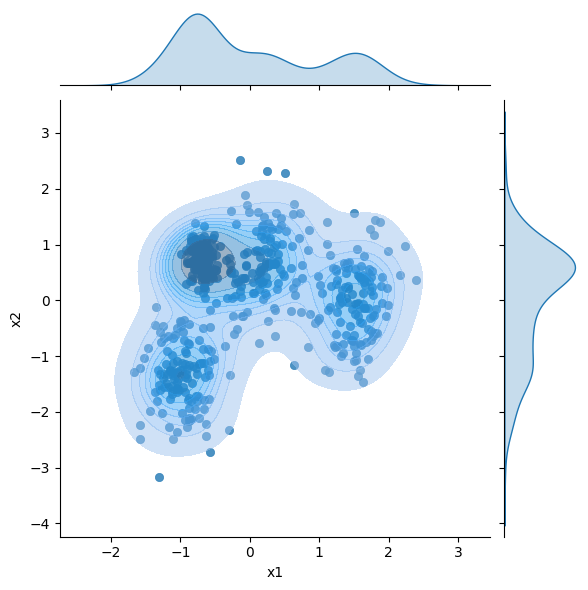

In [9]:
# create scatter-density joint plot
j = sns.jointplot(data=df_scaled, x= 'x1', y= 'x2', 
                  kind= 'kde', fill= True, zorder= 1,
                  height= 6, alpha= 0.5, palette= 'tab10'
                 )
j.plot_joint(sns.scatterplot, alpha= 0.8, color= sns.color_palette("tab10")[0], zorder= 0, edgecolor= None)
plt.show()

From the joint plot, it appears as though the data is composed of three clusters. One of the clusters is more dense than the other two which may present issues depending on our clustering method. Overall, the clusters seems fairly well defined without much overlap.

# K-Means Clustering

Estimate the optimum number of clusters present in the dataset using the following methods:
1. Elbow Method
2. Silhouette Score
3. Davies-Bouldin Score


In [10]:
# find inertia, silhouette, and davies for each cluster

# np arrays to hold results
inertia_vs_k = np.empty((0, 2))
silhouette_score_vs_k = np.empty((0, 2))
davies_bouldin_vs_k = np.empty((0, 2))

for k in np.arange(2, 21, 1, dtype= int):
    # inertia
    kmeans = KMeans(n_clusters= k, init= 'k-means++', random_state=215).fit(df_scaled)
    inertia_vs_k = np.vstack([inertia_vs_k, np.array([k, kmeans.inertia_])])

    # silhouette
    kmeans = KMeans(n_clusters= k, init= 'k-means++', random_state=215).fit(df_scaled)
    silhouette_score_vs_k = np.vstack([silhouette_score_vs_k, [k, silhouette_score(X= df_scaled, labels= kmeans.labels_)]])

    # davies bouldin
    kmeans = KMeans(n_clusters= k, init= 'k-means++', random_state=215).fit(df_scaled)
    davies_bouldin_vs_k = np.vstack([davies_bouldin_vs_k, [k, davies_bouldin_score(X=df_scaled, labels= kmeans.labels_)]])

# get optimal davies b
opt_db_score = davies_bouldin_vs_k[davies_bouldin_vs_k[:, 1].argmin()]

Show a graph of each of the methods versus the number of clusters k.

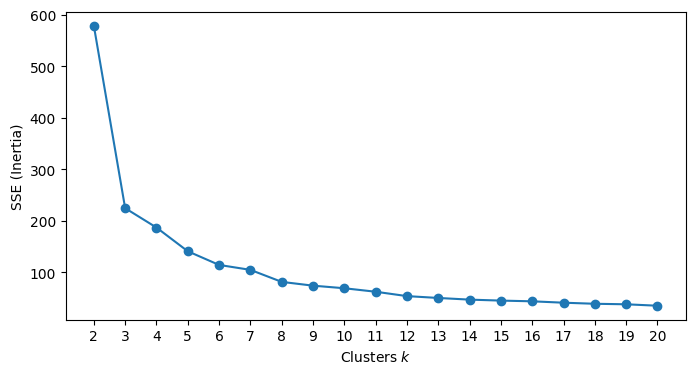

In [11]:
# create elbow plot to understand optimal # of clusters    
plt.figure(figsize= (8, 4))
plt.scatter(x= inertia_vs_k[:, 0], y= inertia_vs_k[:, 1])
plt.plot(inertia_vs_k[:, 0], inertia_vs_k[:, 1])
plt.xlabel('Clusters $k$')
plt.ylabel('SSE (Inertia)')
plt.xticks(ticks= np.arange(2, 21, 1))
plt.show()

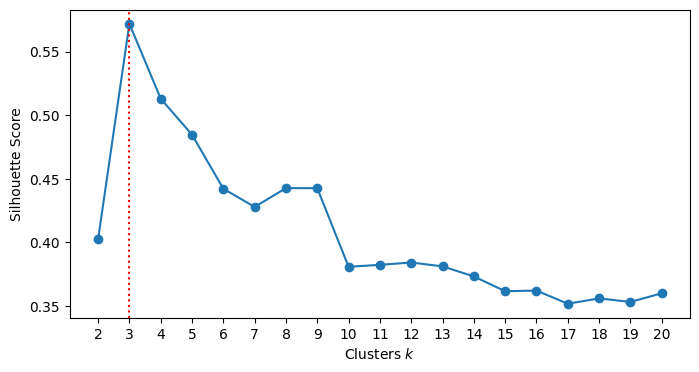

In [12]:
# plot silouhette score
opt_k = silhouette_score_vs_k[silhouette_score_vs_k[:, 1].argmax()]
fig, ax = plt.subplots(1, 1, figsize= (8, 4))
ax.plot(silhouette_score_vs_k[:, 0], silhouette_score_vs_k[:, 1], marker= 'o')
ax.set_xticks(ticks= np.arange(2, 21, 1))
ax.axvline(x= opt_k[0], c= 'red', linestyle= ':')
ax.set_ylabel('Silhouette Score')
ax.set_xlabel('Clusters $k$')
plt.show()

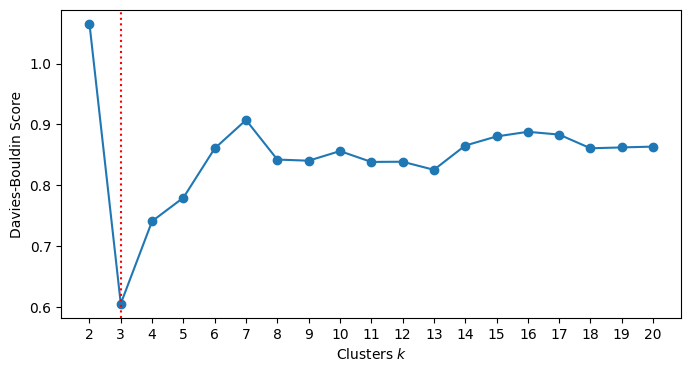

In [13]:
# plot davies bouldin scores
fig, ax= plt.subplots(1, 1, figsize= (8, 4))
ax.scatter(x= davies_bouldin_vs_k[:, 0], y= davies_bouldin_vs_k[:, 1])
ax.plot(davies_bouldin_vs_k[:, 0], davies_bouldin_vs_k[:, 1])
ax.set_ylabel('Davies-Bouldin Score')
ax.set_xlabel('Clusters $k$')
ax.axvline(x= opt_db_score[0], c= 'r', linestyle= ':')
ax.set_xticks(np.arange(2, 21, 1))
plt.show()

Across the elbow plot, silhouette score, and davies-bouldin score, three was the optimal number of clusters, which agrees with the intuition from the joint plot.

Fit a K-Means clustering algorithm with the optimal k value , and store the trained clusterer

In [14]:
# k-means clustering with 3 (optimal) number of clusters
kmeans_opt = KMeans(n_clusters= 3, init= 'k-means++', random_state=215).fit(df_scaled)
centers_km = kmeans_opt.cluster_centers_
silhouette_coefficients_km  = silhouette_samples(df_scaled, kmeans_opt.labels_)

In [15]:
# get labels for km model
labels_km = kmeans_opt.predict(df_scaled)

# Gaussian Mixture Model

Estimate the optimal number of clusters from AIC/BIC calculations included within the GaussianMixture method.

In [16]:
# find AIC/BIC for each cluster
bic_aic = np.empty((0, 3))
for k in np.arange(start= 2, stop= 21, step= 1, dtype= int):
    gm = GaussianMixture(n_components= k, random_state=215).fit(df_scaled)
    bic_aic = np.vstack([bic_aic, np.array([k, 
                                            gm.bic(df_scaled), 
                                            gm.aic(df_scaled)])]) 
    

Show a graph of AIC and BIC versus the number of clusters.

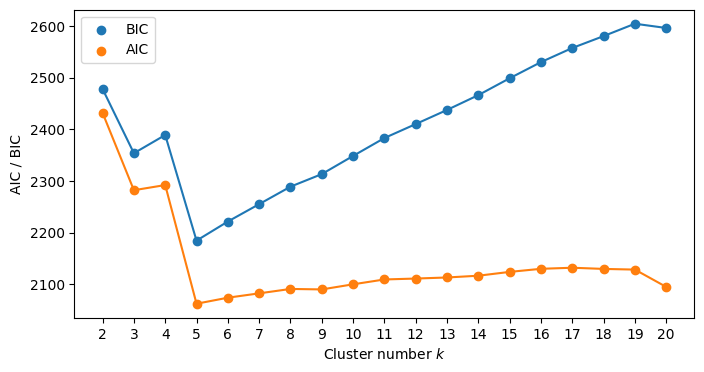

In [17]:
# plot AIC / BIC scores
plt.figure(figsize= (8, 4))
plt.scatter(x= bic_aic[:, 0], y= bic_aic[:, 1], label= 'BIC')
plt.plot(bic_aic[:, 0], bic_aic[:, 1])
plt.scatter(x= bic_aic[:, 0], y= bic_aic[:, 2], label= 'AIC')
plt.plot(bic_aic[:, 0], bic_aic[:, 2])
plt.xlabel('Cluster number $k$')
plt.ylabel('AIC / BIC')
plt.xticks(ticks= np.linspace(2, 20, 19, dtype= int))
plt.legend()
plt.show()

The Gaussian mixture model identies 5 as the optimal number of clusters. 

Fit a Gaussian Mixture Model with the optimal k value selected, and store the trained mixture model.

In [18]:
# fit GM model with optimal k
gm_opt = GaussianMixture(n_components=5, random_state=215).fit(df_scaled)

# get labels for gm
labels_gm = gm_opt.predict(df_scaled)

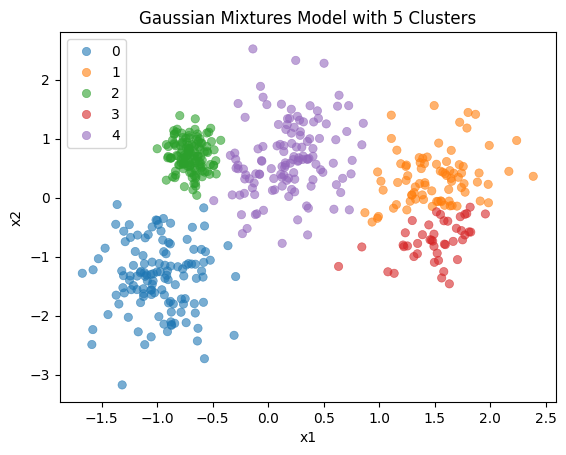

In [19]:
# create GM scatterplot color coded by cluster
sns.scatterplot(data= df_scaled, x= 'x1', y= 'x2', 
                hue= labels_gm, 
                alpha= 0.6, palette= 'tab10', edgecolor= None)

plt.title('Gaussian Mixtures Model with 5 Clusters')
plt.show()

# DBSCAN

In [20]:
# min_samples = 2f where f is the dimension of the data (f=2)
min_sample = 4

Calculate the optimal value for the epsilon hyperparameter

In [21]:
# instantiate and fit nearest neighbors model with 3 neighbors
nbrs = NearestNeighbors(n_neighbors=min_sample).fit(df_scaled)
distances, indices = nbrs.kneighbors(df_scaled)

# set k
k = min_sample - 1

## Calculate distance to kth nearest neighbor (knn)
knn_distances = np.sort(distances[:, k])

## Scale knn to [0, 1]
scaled_knn_dists = (knn_distances - knn_distances.min()) / (knn_distances.max() - knn_distances.min())

## Scale indices to [0, 1]
scaled_idx = np.linspace(start= 0, stop= 1, num= int(scaled_knn_dists.shape[0]))

## Construct the two curves
knn_coords = np.concatenate([scaled_idx, scaled_knn_dists]).reshape(2, -1).T
line_coords = np.concatenate([scaled_idx, scaled_idx]).reshape(2, -1).T

## Calculate distances between two curves
line_to_knn_dists = cdist(XA = knn_coords, XB= line_coords)

## Identify the largest smallest distance
idx_opt = line_to_knn_dists.min(axis= 1).argmax()

## Extract the optimum epsilon value
opt_eps = knn_distances[idx_opt]

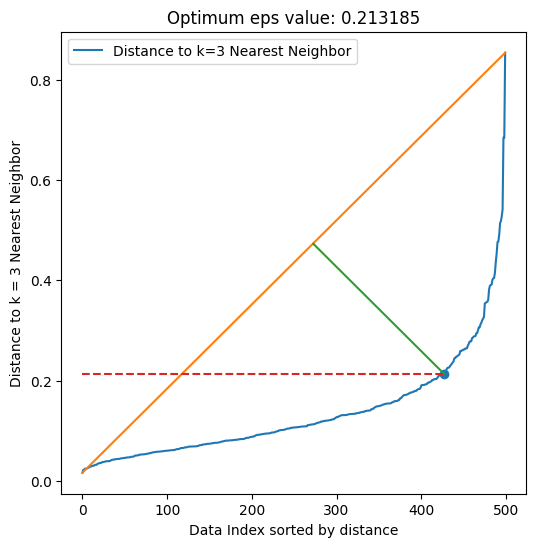

In [22]:
# contruct perpendicular line to optimal eps
perp_line = np.array([
    [idx_opt, opt_eps],
    [line_coords[line_to_knn_dists[idx_opt].argmin()][0] * knn_distances.shape[0], 
     line_coords[line_to_knn_dists[idx_opt].argmin()][1] * (knn_distances.max() - knn_distances.min()) + knn_distances.min()
    ]
])

# plot optimal eps
plt.figure(figsize= (6, 6))
plt.plot(knn_distances, label= f'Distance to k={k} Nearest Neighbor')
plt.plot(np.linspace(start= knn_distances.min(), stop= knn_distances.max(), num= int(knn_distances.shape[0])))
plt.scatter(x= idx_opt, y= opt_eps)
plt.plot(perp_line[:, 0], perp_line[:, 1])
plt.plot([0, idx_opt], [opt_eps, opt_eps], linestyle= '--')
plt.ylabel(f'Distance to k = {int(k)} Nearest Neighbor')
plt.xlabel('Data Index sorted by distance')
plt.title(f'Optimum eps value: {np.round(opt_eps, 6)}')
plt.legend()
plt.show()

Fit a DBSCAN clusterer with these hyperparameters, and store the trained mixture model.

In [23]:
# instantiate and fit DBSCAN
dbscan_opt = DBSCAN(min_samples=min_sample, eps=opt_eps).fit(df_scaled)
labels_db = dbscan_opt.labels_
clstr, cnts = np.unique(dbscan_opt.labels_, return_counts= True)

Create a plot of data set color coded by the cluster labels.

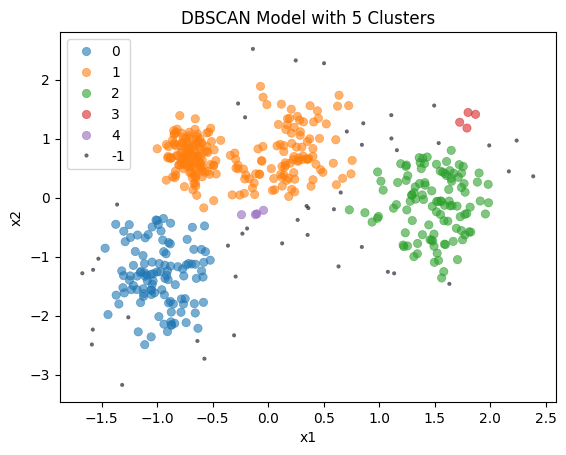

In [24]:
# create DBSCAN scatterplot color coded by cluster
sns.scatterplot(data= df_scaled[dbscan_opt.labels_ > -1], x= 'x1', y= 'x2', 
                hue= labels_db[dbscan_opt.labels_ > -1], 
                alpha= 0.6, palette= 'tab10', edgecolor= None)

sns.scatterplot(data= df_scaled[dbscan_opt.labels_ == -1], x= 'x1', y= 'x2', 
                hue= labels_db[dbscan_opt.labels_ == -1], alpha= 0.6, 
                palette= 'rocket', s= 7, edgecolor= None)

plt.title('DBSCAN Model with 5 Clusters')
plt.show()

Remove outliers (labels_ = -1)
1. Copy the scaled data set into a new data set named dbscan_df
2. Add a new column to dbscan_df for the labels predicted from the best DBSCAN
clusterer
3. Remove all rows with these labels = -1
4. Show a graph of dbscan_df color coded by cluster labels.

In [25]:
# copy scaled data
dbscan_df = df_scaled.copy(deep=True)

# add column of prediction labels from DBSCAN
dbscan_df['label'] = dbscan_opt.labels_

# remove -1 (outliers)
dbscan_df = dbscan_df.loc[dbscan_df.label != -1,]

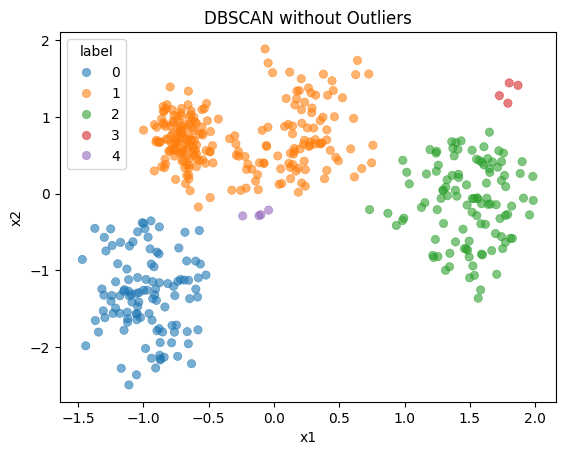

In [26]:
# plot DCSCAN clusters
sns.scatterplot(data=dbscan_df, x= 'x1', y= 'x2', 
                hue= 'label', alpha= 0.6, 
                palette= 'tab10', edgecolor= None)
plt.title('DBSCAN without Outliers')
plt.show()

In [27]:
# instances in cluster 3
dbscan_df.loc[dbscan_df.label == 3,].shape[0]

4

In [28]:
# instances in cluster 4
dbscan_df.loc[dbscan_df.label == 4,].shape[0]

4

With outliers removed, the plot of DBSCAN clusters shows 5 distinct clusters. Three clusters are those we were able to visually identify using the joint plot. The other two are small offshoots that both have the minimum number of samples required for a cluster, 4. Since the distance hyperparameter found was a conservative estimate, I would want to adjust this upward to start to remove those 2 small clusters.

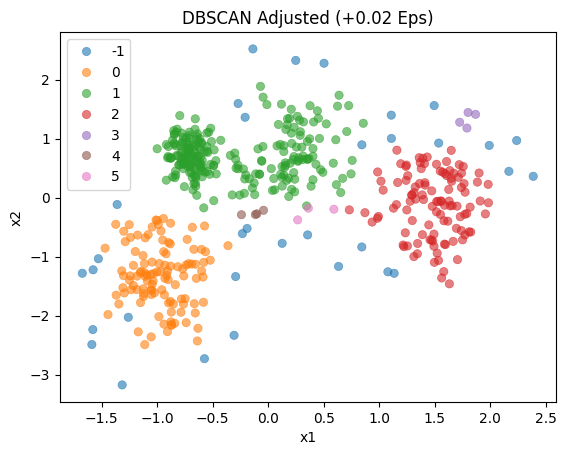

In [29]:
# adjust distance feature in DBSCAN mode
dbscan_opt_adj = DBSCAN(min_samples=min_sample, eps=opt_eps+0.02).fit(df_scaled)
labels_db_adj = dbscan_opt_adj.labels_
clstr, cnts = np.unique(dbscan_opt.labels_, return_counts= True)

# plot adjusted model
# plot DCSCAN clusters
sns.scatterplot(data=df_scaled, x= 'x1', y= 'x2', 
                hue= labels_db_adj, alpha= 0.6, 
                palette= 'tab10', edgecolor= None)
plt.title('DBSCAN Adjusted (+0.02 Eps)')
plt.show()

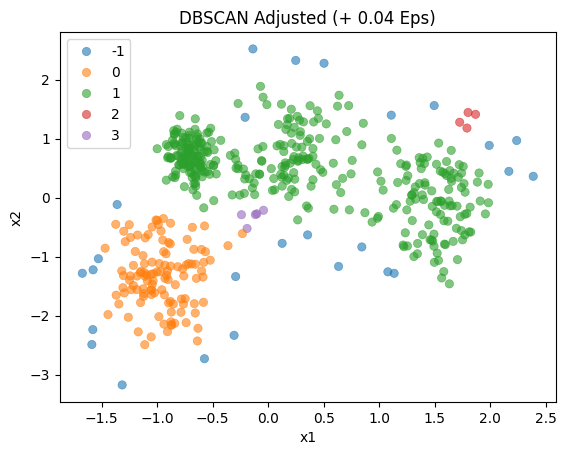

In [30]:
# adjust distance feature in DBSCAN mode
dbscan_opt_adj = DBSCAN(min_samples=min_sample, eps=opt_eps+0.04).fit(df_scaled)
labels_db_adj = dbscan_opt_adj.labels_
clstr, cnts = np.unique(dbscan_opt.labels_, return_counts= True)

# plot adjusted model
# plot DCSCAN clusters
sns.scatterplot(data=df_scaled, x= 'x1', y= 'x2', 
                hue= labels_db_adj, alpha= 0.6, 
                palette= 'tab10', edgecolor= None)
plt.title('DBSCAN Adjusted (+ 0.04 Eps)')
plt.show()

Adjusting the distance hyperparameter (+0.02) increases the number of clusters to 6 or combined two of the larger clusters into one cluster (+0.04). Since my intention was to keep the three large cluster and remove the two smaller clusters, I will do with the unadjusted, optimized DBSCAN model.

# Model Evaluation
For each clustering method, construct a plot of the data color coded to the cluster label predictions.

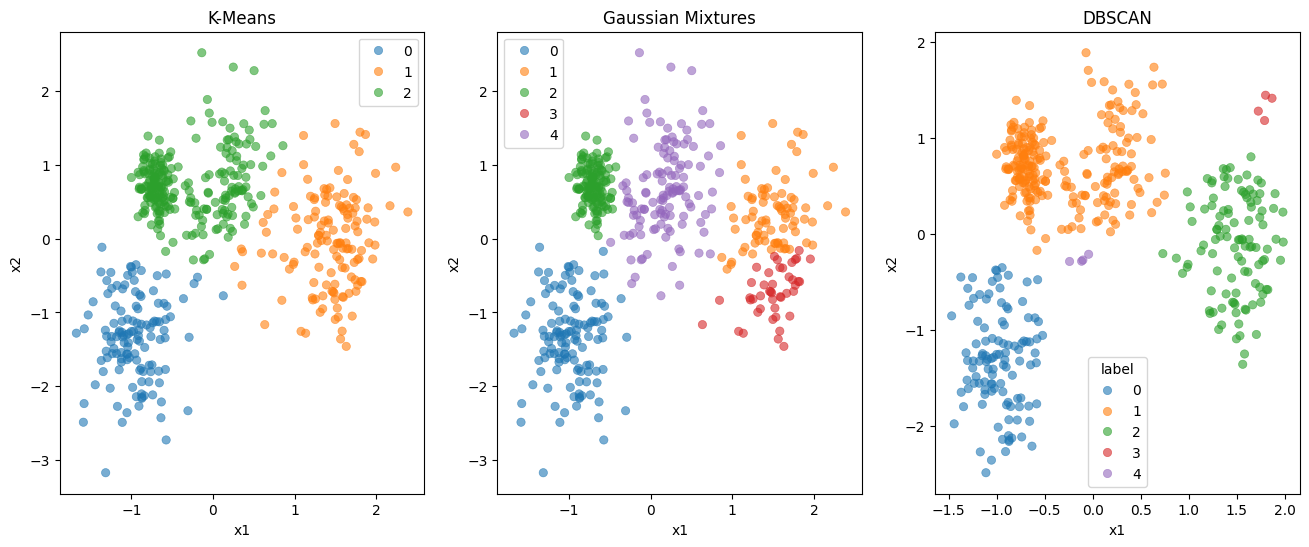

In [31]:
# set three subplots
fig, ax = plt.subplots(nrows= 1, ncols= 3, figsize=(16, 6))

# K-Means
sns.scatterplot(data= df_scaled, x= 'x1', y= 'x2', 
                hue= labels_km, ax=ax[0],
                alpha= 0.6, palette= 'tab10', edgecolor= None)
ax[0].set_title('K-Means')

# GM
sns.scatterplot(data= df_scaled, x= 'x1', y= 'x2', 
                hue= labels_gm, ax=ax[1],
                alpha= 0.6, palette= 'tab10', edgecolor= None)
ax[1].set_title('Gaussian Mixtures')

# DBSCAN
sns.scatterplot(data=dbscan_df, x= 'x1', y= 'x2', 
                hue= 'label', ax=ax[2],
                alpha= 0.6, palette= 'tab10', edgecolor= None)
ax[2].set_title('DBSCAN')

plt.show()

K-Means's clusters most clearly aligned with what we see in our visual inspection but DBSCAN was able to remove outliers which created the clearest picture of where these clusters exist. For this reason, DBSCAN produced the best clustering. 

K-Means clustering works best with isotropic blobs where our clusters are a bit more elongated. K-Means found 3 distinct clusters but those clusters were influenced by the outliers identified in DBSCAN. 

Gaussian Mixtures and DBSCAN work better for non-uniform shapes. Both Gaussian Mixtures and DBSCAN found 5 clusters. Gassian Mixtures' fourth and fifth clusters are a splitting of two of the clusters found in K-Means. Ultimately, it seems like this method would have had better performance with a lower number of clusters than the optimal number identified by AIC and BIC. 

In DBSCAN, the additional 2 clusters found were small groups of clusters that were separate enough from the 3 main clusters to not be consider part of them, and dense enough to not be considered outliers. Whether this dataset required three or five clusters could be up for debate, but in five cluster case, the DBSCAN clustering is more intuitive than that of the Gaussian Mixtures.


Gather or calculate the Silhouette Score and Davies-Bouldin Score for each of the three
clusterings.

In [32]:
# k-means silhouette - best silhouette score
silhouette_score(X=df_scaled, labels= labels_km)

np.float64(0.5718560352460762)

In [33]:
# gaussian mixtures silhouette
silhouette_score(X=df_scaled, labels= labels_gm)

np.float64(0.4705108164980146)

In [34]:
# DBSCAN silhouette
silhouette_score(X=dbscan_df.drop(columns=['label']), labels=dbscan_df.label)

np.float64(0.36515197939404076)

In [35]:
# k-means davies bouldin
davies_bouldin_score(X=df_scaled, labels= labels_km)

np.float64(0.605148539236355)

In [36]:
# gaussian mixtures davies bouldin
davies_bouldin_score(X=df_scaled, labels= labels_gm)

np.float64(0.7754958073490065)

In [37]:
# DBSCAN davies bouldin - best davies boudin
davies_bouldin_score(X=dbscan_df.drop(columns=['label']), labels=dbscan_df.label)

np.float64(0.5383835734416957)

The k-means method performed best with the silhouette score and the DBSCAN performed best for Davies Bouldin. Silhouette and Davies Bouldin both favor compactness, which DBSCAN does not always produce but k-means will. For that reason, we must take the take a more holistic approach to our cluster assessment, and determine that DBSCAN produces the best clusters.